In [1]:
# Call the relevant python packages
import numpy as np
import pandas as pd
import glob, os

import matplotlib
import matplotlib.pyplot as plt

import scipy.constants as const
import scipy.stats as stats

from astropy import units as u
from astropy.io import ascii, fits
from astropy.table import join, hstack, Table, Column, vstack
from astropy.coordinates import Angle, Latitude, Longitude, SkyCoord

from sedfitter import fit, plot, plot_params_1d, plot_params_2d
from sedfitter import filter_output, write_parameters, write_parameter_ranges
from sedfitter.extinction import Extinction

import seaborn as sns
sns.set_context("paper")

%matplotlib inline

In [20]:
# Read in the parameter and parameter range files - both are required as inputs
#param_file = '/Disk/ds-sopa-ifa-ug/s1625982/fred/Output_SED/All_Good_YSO.csv'
param_file = 'Prob_YSO_param.csv'
p_data = ascii.read(param_file)
#.sort('source_name')
#param_range_file = '/Disk/ds-sopa-ifa-ug/s1625982/fred/Output_SED/All_Good_YSO_ranges.csv'
param_range_file = 'Prob_YSO_ranges.csv'
pr_data = ascii.read(param_range_file)
#pr_data.sort('source_name')

# Define solar radius, Stefan-Boltzmann constant and temperature of the Sun
sigma = const.Stefan_Boltzmann
R_sun = 6.957e+08 * u.m
T_sun = 5778 * u.Kelvin

# Define function to write a flag to a column at indexed positions.
# This writes the flags to the parameter file (not the ranges file)
def write_column(table,crit,name,flag):
    print("Number of stars in cut "+name+' '+str(flag)+": {}".format(len(crit[0])))
    for i in range(len(crit[0])):
        table[name][crit[0][i]]=flag

# Create columns for luminosity in both files and calculate in units of L☉
p_data['luminosity']=0
p_data['luminosity']=(((p_data['rstar'])**2)*((p_data['tstar'])**4)/T_sun**4)
pr_data['lum_best']=0
pr_data['lum_best']=(((pr_data['rstar_best'])**2)*((pr_data['tstar_best'])**4)/T_sun**4)

# Determine YSO evolutionary stages in param file
p_data['stage']=0
idx_stage_1 = np.where(p_data['mdot']>=p_data['massc']*10**-6)
idx_stage_2 = np.where((p_data['mdot']<p_data['massc']*10**-610**-6) & (p_data['mdisk']/p_data['massc']>10**-6))
idx_stage_3 = np.where((p_data['mdot']<p_data['massc']*10**-610**-6) & (p_data['mdisk']/p_data['massc']<10**-6))
write_column(p_data,idx_stage_1,'stage',1)
write_column(p_data,idx_stage_2,'stage',2)
write_column(p_data,idx_stage_3,'stage',3)

# Determine YSO evolutionary stages in ranges file
pr_data['stage']=0
idx_stage_1 = np.where(pr_data['mdot_best']>=pr_data['massc_best']*10**-6)
idx_stage_2 = np.where((pr_data['mdot_best']<pr_data['massc_best']*10**-6) & (pr_data['mdisk_best']/pr_data['massc_best']>10**-6))
idx_stage_3 = np.where((pr_data['mdot_best']<pr_data['massc_best']*10**-6) & (pr_data['mdisk_best']/pr_data['massc_best']<10**-6))
write_column(pr_data,idx_stage_1,'stage',1)
write_column(pr_data,idx_stage_2,'stage',2)
write_column(pr_data,idx_stage_3,'stage',3)

# Print the total number of fits in the parameter file
num_fits = len(p_data['source_name'])
print("The number of fits in this file is",num_fits)
# Print the total number of sources in the ranges file
num_sources = len(pr_data['source_name'])
print("The number of sources in this file is",num_sources)

# Build array of n_fits corresponding to each source.
# This writes a '1' to a new column to flag if that row starts a new source
source_num = 0
p_data['new_source?']=0
arr_new_source = np.array([])
for i in range(num_fits):
    new_source = p_data['source_name'][i] - source_num
    if new_source == 1:
        arr_new_source = np.append(arr_new_source,np.array([i]))
        p_data['new_source?'][i]=1
    source_num = p_data['source_name'][i]

# Define a list of parameters to find MADs for
param_list = ['chi2','av','scale','time','massc','rstar','tstar','mdot',
             'rmax','theta','rmine','mdisk','rmaxd','rmind','rmind(au)',
             'rc','rchole','zmin','a','b','alpha','rhoconst','rhoamb',
             'mdotdisk','incl.','av_int','tau60','ltot','h100']

#################################################################################################
###################################### MIGHT DELETE LATER #######################################
#################################################################################################
    
# Find MAD for each parameter above
# Set up empty columns for each MAD in ranges file
p_data['L_MAD']=0
pr_data['L_MAD']=0
for i in range(len(param_list)):
    param_mad_name = param_list[i]+'_MAD'
    p_data[param_mad_name]=0
    pr_data[param_mad_name]=0
    
# For each source in the table find the MADs
idx_new_source = np.where(p_data['new_source?']==1)

# Cycle through each fit for each source to get luminosity MAD
counter = 0
for i in range(num_sources):
    counter = counter + 1
    L_best = pr_data['lum_best'][i]
    n_fits_for_source = pr_data['n_fits'][i]
    arr_MAD = np.array([])
    if n_fits_for_source > 1:
        for j in range(n_fits_for_source-1):
            dev = np.array([abs(L_best - p_data['luminosity'][counter])])
            arr_MAD = np.append(arr_MAD, dev)
            counter = counter + 1
        MAD_value = np.median(arr_MAD)
    else:
        MAD_value = 0
    pr_data['L_MAD'][i] = MAD_value
    
##################################################################################################
    
# Run this again for all other non-user-calculated parameters
# Cycle through all parameters listed above
for n in range(len(param_list)):
    counter = 0
    for i in range(num_sources):
        counter = counter + 1
        param_best_name = param_list[n]+'_best'
        param_best = pr_data[param_best_name][i]
        n_fits_for_source = pr_data['n_fits'][i]
        arr_MAD = np.array([])
        if n_fits_for_source > 1:
            for j in range(n_fits_for_source-1):
                dev = np.array([abs(param_best - p_data[param_list[n]][counter])])
                arr_MAD = np.append(arr_MAD, dev)
                counter = counter + 1
            MAD_value = np.median(arr_MAD)
        else:
            MAD_value = 0
        param_mad_name = param_list[n]+'_MAD'
        pr_data[param_mad_name][i] = MAD_value

Number of stars in cut stage 1: 24814
Number of stars in cut stage 2: 40477
Number of stars in cut stage 3: 7174
Number of stars in cut stage 1: 38
Number of stars in cut stage 2: 16
Number of stars in cut stage 3: 9
The number of fits in this file is 47651
The number of sources in this file is 63


In [16]:
#pr_data.show_in_notebook()
ascii.write(pr_data,'Possible_YSO_ranges_analysed.txt',format='csv')
ascii.write(p_data,'Possible_YSO_analysed.txt',format='csv')

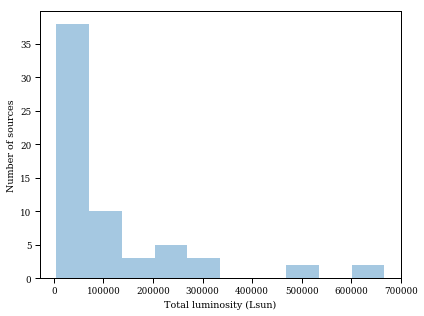

In [21]:
cat_name  ='Prob'

'''
fig = plt.figure(figsize=(6,4.5))
param_best_name = 'stage'
ax = sns.distplot(pr_data[param_best_name] ,kde=False, bins=10)
#ax = sns.countplot(pr_data[param_best_name], color='steelblue')
ax.set_yscale('log')
ax.set_ylabel('Number of sources')
plt.tight_layout()
#ax.set_xticks()
save_name = str(cat_name+'hist_'+param_best_name+'.pdf')
plt.savefig(save_name, bbox_inches='tight')

# Parameter histogram function
useful_param_list = ['chi2']
#,'av','time','massc','rstar','tstar','mdot','mdisk','mdotdisk','ltot']
for i in range(len(useful_param_list)):
    fig = plt.figure(figsize=(6,4.5))
    param_best_name = useful_param_list[i]+'_best'
    ax = sns.distplot(pr_data[param_best_name] ,kde=False, bins=10)
    #ax = sns.countplot(pr_data[param_best_name], color='steelblue')
    ax.set_yscale('log')
    ax.set_ylabel('Number of sources')
    plt.tight_layout()
    #ax.set_xticks()
    save_name = str(cat_name+'hist_'+param_best_name+'.pdf')
    plt.savefig(save_name, bbox_inches='tight')
'''
    
fig = plt.figure(figsize=(6,4.5))
param_best_name = 'ltot_best'
ax = sns.distplot(pr_data[param_best_name] ,kde=False, bins=10)
#ax = sns.countplot(pr_data[param_best_name], color='steelblue')
ax.set_ylabel('Number of sources')
ax.set_xlabel('Total luminosity (Lsun)')
plt.tight_layout()
#ax.set_xticks()
save_name = str(cat_name+'hist_'+param_best_name+'.pdf')
plt.savefig(save_name, bbox_inches='tight')